In [1]:
%run "../../PyUtils/common.ipynb"
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcess
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.formula.api as smf
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

han1="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20patient_data_table";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
kimj="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kimj";
leeh="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20leeh";
sony="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20sony";
kuky="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kuky";

fileName = sony;

dfOriginal = LoadDataSet(fileName, checkForDateTime=False);
displayDFs (dfOriginal, maxrows=3 )
#for c in dfOriginal.columns: print (c,  end=', ')

<IPython.core.display.Javascript object>

In [2]:
df=dfOriginal.copy()

#1. Remove all the rows that does not have any pef values 
df.insert(4, 'npt',0)
df.insert(4, 'pef',0)
df.npt = pd.notnull(df.pef1)*1 + pd.notnull(df.pef2)*1 + pd.notnull(df.pef3)*1
df = df[df.npt > 0]
df=df.reset_index(drop=True)
df.pef = (df.pef1 + df.pef2 + df.pef3)/df.npt

#2. Combine 
df=df.fillna(0)
df.loc[df.timeofday == 'null', 'timeofday'] = "00:00:00"
sdttm = df.dateofmeasure + " " + df.timeofday 
df.insert(0, 'sdttm', sdttm)
df.sdttm = pd.to_datetime(df.sdttm)

df.sort_values(by='sdttm', ascending=True, inplace=True)
drps  = "cname, ampm, timeofday, dateofmeasure, npt, pef1, pef2, pef3, pef, indexpef".split(', ')
df=df.drop(drps, axis=1, errors='ignore')
df=df.reset_index(drop=True)

## <== do the following for SAP PA tool
#pef = df.pef;
#df=df.drop(['pef'], axis=1)
#df.insert(1, 'pef1', pef)

#pef[-10:]=0     # Set last 10 to zero for predictions
#df.insert(1, 'pef', pef)
#df.to_csv("HanD/hand1.csv", sep=';')

df1 = df.copy()
df1 = df1.set_index(df1.sdttm)
df1=df1.drop('sdttm', axis=1, errors='ignore')

columns = '''pefmax,so2,co,o3,no2,temperaturec,windspeedms,precipitationpercent,vaporpressurehpa,
dewpointtemperaturec,airpressurehpa,sealevelpressurehpa,groundtemperaturec,tmax,amax,tmin'''
#amin,pmin,tmaxlesstmin,amaxlessamin,pmaxlesspmin'''
cs = [c.strip() for c in columns.split(',')]

df1=df1[cs]
#HTML(df1.to_html())
displayDFs (df1, maxrows=3 )

In [3]:
CREATE_ROLLING_WINDOW=True

if ( CREATE_ROLLING_WINDOW):
    for c in "so2,co,o3,no2".split(','):
        n = c+"_5combined";
        df1[n] = 0
        df1[n] = pd.rolling_sum(df1[c], window=5)
        n = c+"_4combined";
        df1[n] = 0
        df1[n] = pd.rolling_sum(df1[c], window=4)
        n = c+"_3combined";
        df1[n] = 0
        df1[n] = pd.rolling_sum(df1[c], window=3)
        n = c+"_2combined";
        df1[n] = 0
        df1[n] = pd.rolling_sum(df1[c], window=2)

    df1=df1[5:]
    df1

pefmax, so2, co, o3, no2, temperaturec, windspeedms, precipitationpercent, vaporpressurehpa, dewpointtemperaturec, airpressurehpa, sealevelpressurehpa, groundtemperaturec, tmax, amax, tmin, so2_5combined, so2_4combined, so2_3combined, so2_2combined, co_5combined, co_4combined, co_3combined, co_2combined, o3_5combined, o3_4combined, o3_3combined, o3_2combined, no2_5combined, no2_4combined, no2_3combined, no2_2combined, 

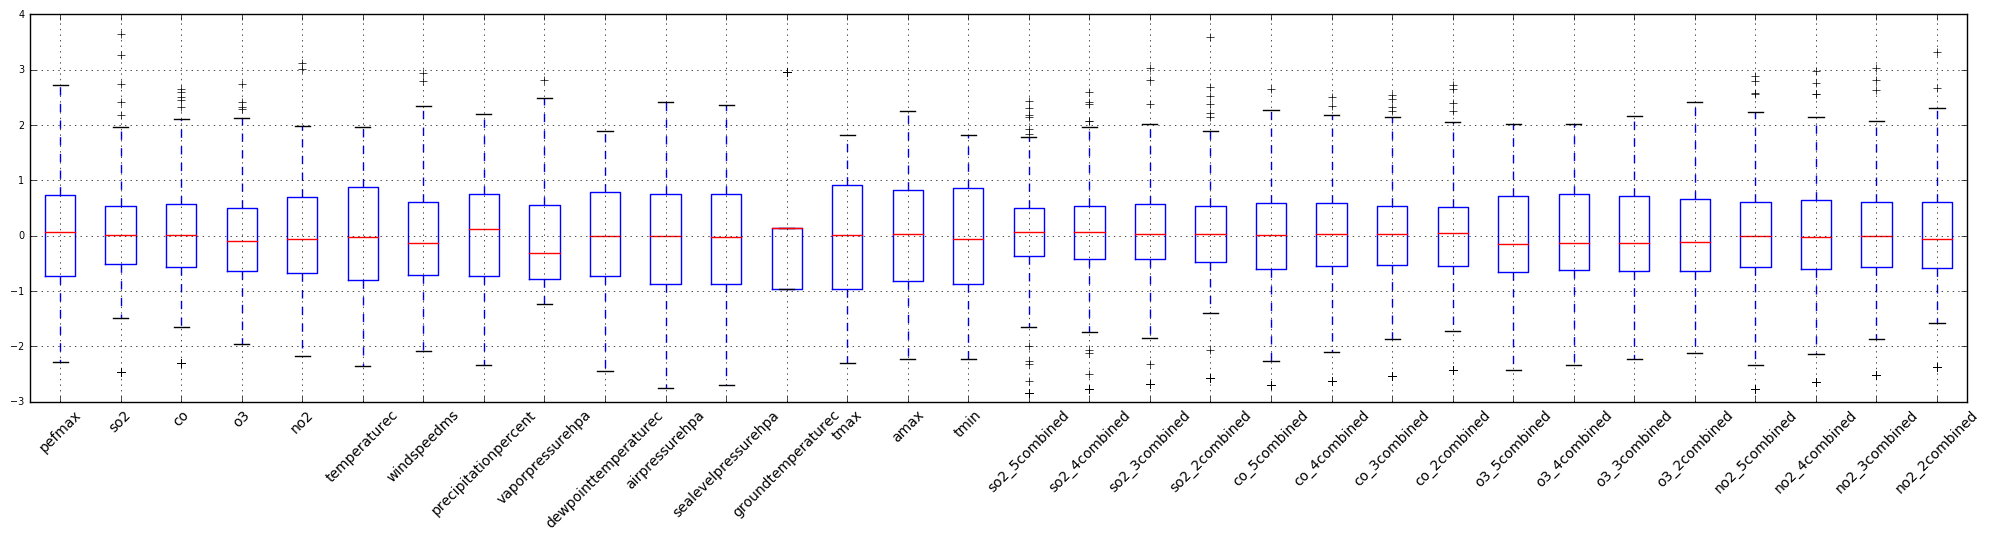

In [4]:
#Outlier analysis

for c in df1.columns:
    print(c, end=', ')

Y_SCALER = None
#Normalize the input and save the scalar for outcome variable "pefmax" in this case.
scaler = StandardScaler()
dp = prepareDF(df1, True)
for c in dp.columns:
    if ( c == 'pefmax'):
        Y_SCALER = StandardScaler()
        dp[c] = Y_SCALER.fit_transform(dp[c])
    else:
        dp[c] = scaler.fit_transform(dp[c])

plt.figure(figsize=(25, 5))
dp.boxplot(rot=45);
plt.show()

REMOVE_OUTLIERS = False
if ( REMOVE_OUTLIERS ):
    dpo= dp.copy()
    #from scipy import stats
    good = dp[(np.abs(stats.zscore(df1)) <= 3).all(axis=1)]
    outl = dp[(np.abs(stats.zscore(df1)) > 3).any(axis=1)]
    #outl
    dp=good
    plt.figure(figsize=(25, 5))
    good.boxplot(rot=45);
    
    print ("OUTLIERS COUNT: {} ", len(dpo) - len(dp));


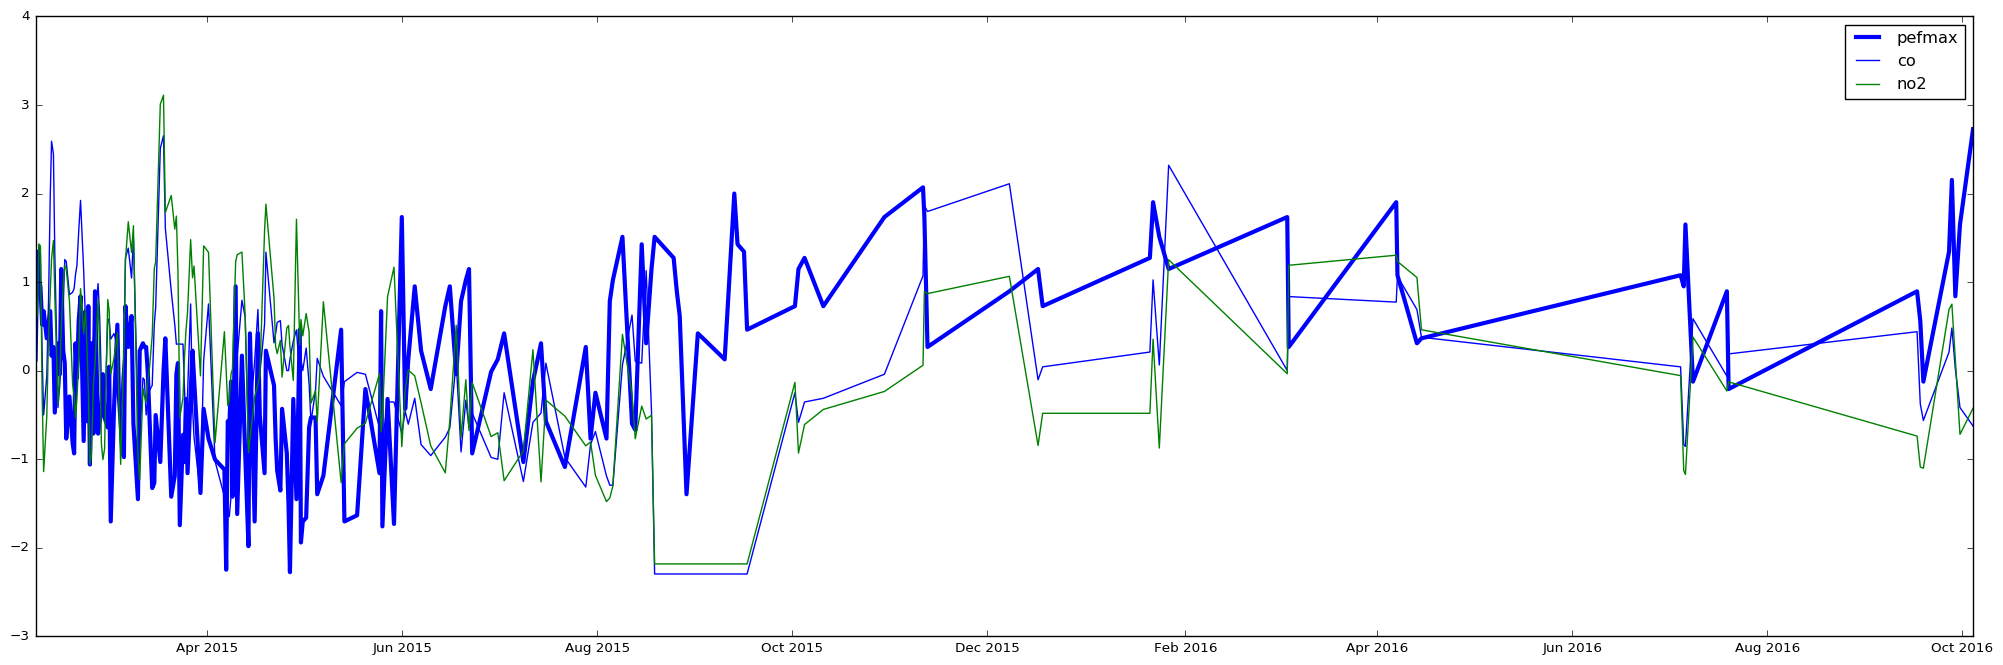

In [5]:
plt.figure(figsize=(25, 8))
plt.rc('font', size=14)

#dp = dp[0:90]
#dp = dp["pef,so2,co,o3,no2,pm10,tmax,so2poi,copoi,o3poi,no2poi,pm10poi,temperaturec".split(',')]
#dp = dp["pef,so2,co,o3,no2,pm10,temperaturec,rainfallmm,windspeedms,vaporpressurehpa".split(',')]
#dp = dp["pef,so2poi,copoi,o3poi,no2poi,pm10poi,temperaturec,rainfallmm,windspeedms,vaporpressurehpa".split(',')]

rolmean = pd.rolling_mean(dp.pefmax, window=14)

plt.plot(dp.index, dp.pefmax, color='b', linewidth=3)
#plt.plot(dp.index, rolmean, color='r', linewidth=2, label='trend')
#plt.plot(dp.index, dp.so2)
plt.plot(dp.index, dp.co)
#plt.plot(dp.index, dp.o3)
plt.plot(dp.index, dp.no2)
#plt.plot(dp.index, dp.pm10)
#plt.plot(dp.index, dp.tmax)
#plt.plot(dp.index, dp.amax)
#plt.plot(dp.index, dp.pmax)

plt.legend()

In [6]:
PLOT_SCATTER=False
if (PLOT_SCATTER):
    c="r,g,b,c,m,y,k,w".split(",")
    #dpc = dp["pefmax,so2,co,o3,no2,tmax,so2poi,copoi,o3poi,no2poi,pm10poi,temperaturec".split(',')]
    dpc=dp;
    axes = scatter_matrix(dpc, alpha=0.2, diagonal='kde', figsize=(13, 10)); # diagonal can be 'hist';

    corr = dpc.corr().as_matrix()
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
    #plt.show()


In [7]:
def run_reg(X,y,reg_class,printDebug = False , reg=None, scaler = None):
    # Construct a kfolds object
    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
    y_pred = y.copy()

    # Iterate through folds\
    i = 0;
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = reg_class(**kwargs) if (reg is None)  else reg;
        if (printDebug): print ("*",i, end ="");
        reg.fit(X_train,y_train)
        y_pred[test_index] = reg.predict(X_test)
        i = i +1;
    if (printDebug): print ("*", end="");
    
    if ( scaler ):
        y1 = scaler.inverse_transform(y)
        y2 = scaler.inverse_transform(y_pred)
    else:
        y1 = y;
        y2 = y_pred;
        
    m = mean_squared_error(y1, y2)
    r  = np.corrcoef(y, y_pred)[0,1]
    r2 = r2_score(y,y_pred)
    
    return y_pred, m, r, r2, clf


import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
R = rpy2.robjects.r
DTW = None; #importr('dtw')
def DTW(l1,l2, keep=True):
    alignment = R.dtw(l1, l2, keep=keep)
    d = alignment.rx('distance')[0][0]
    return d

SHOW_DTW_WORKING = False;
if (SHOW_DTW_WORKING):
    from pandas_datareader.data import DataReader
    if ('f' not in globals() ):
        f = DataReader("F",  "yahoo", datetime.datetime(2000,1,1), datetime.datetime(2012,1,1))
    f_2008=f[f.index.year==2008][0:50]
    f_2009=f[f.index.year==2009][0:50]
    f_2010=f[f.index.year==2011][0:50]

    d1 = DTW(f_2008, f_2009)
    d2 = DTW(f_2008, f_2010)
    d3 = DTW(f_2009, f_2010)

    plt.figure(figsize=(25, 5))
    plt.plot(f_2008.Volume.values, marker='o', label="2008")
    plt.plot(f_2009.Volume.values, marker='s', label="2009")
    plt.plot(f_2010.Volume.values, marker='d', label="2010")
    plt.legend()

    print( d1 , '= DTW(f_2008, f_2009)' )
    print( d2 , '= DTW(f_2008, f_2010)' )
    print( d3 , '= DTW(f_2009, f_2010)' )

In [8]:
#POLYMINAL FEATURE PREPARATION
# Prepare data for classification

#dp = dp["so2,pef,o3,co,no2,pm10,tmax".split(',')]
dp1 = dp.set_index(pd.Series(range(0,len(dp)) ) )

X = dp1.ix[:, dp1.columns != 'pefmax']
y = dp1.pefmax
X = X.as_matrix().astype(np.float)

##---- Polynomial features
poly=1
p = PolynomialFeatures(poly)
o = p.fit_transform(X)
X = o

In [9]:
def score(y_true,y_pred): 
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    dtw = DTW(y_true, y_pred)
#    print("MSE: {} R2: {}".format(mse,r2))
    score = mse
    score = r2;
    return score

def myscorer():
    return make_scorer(score, greater_is_better=True) # change for false if using R2
#    return make_scorer(score, greater_is_better=False) # change for false if using MSE


def GridSearch(clf, X,y,param_grid, cv=5, scorer=None):
    clfs = "Grid search on {} ".format(str(clf)[0:20] + "..." + str(clf)[-10]) 
    print ("Grid search on: ", clfs)
    #cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring=scorer)
    grid.fit(X, y)

    print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    return grid


RunGridSearch = False

if ( RunGridSearch ):
#    C_range = np.logspace(-2, 10, 13)
#    gamma_range = np.logspace(-9, 3, 5)
#    param_grid = dict(gamma=gamma_range, C=C_range)
#    GridSearch(SVR(), X,y, param_grid, cv=5)
    
#    param_grid = dict(alpha=np.linspace(0.01, 5000, 100));
#    grid = GridSearch(Ridge(random_state=0), X,y, param_grid, cv=5, scorer= myscorer())
    
    param_grid = dict(alpha=np.linspace(.5, 5, 10), gamma=np.linspace(0.01, 1, 10), degree=[1,2,3,4,5,6,7,8], kernel=['rbf','linear']);
    grid = GridSearch(    KernelRidge(kernel='rbf'), X,y, param_grid, cv=5) #, scorer= myscorer())
    
#    param_grid = dict(max_depth=range(10,50), max_features= ['auto', 'sqrt', 'log2'], n_estimators=[10,20,30,40] );
#    GridSearch(RandomForestRegressor(random_state=10), X,y, param_grid, cv=5)

else:
    prev = '''
Grid search SVR
The best parameters are {'C': 1.0, 'gamma': 1000.0} with a score of -0.19

RIDGE: I did scoring on DTW and alpha=50 seems good 

    Grid search on:  Grid search on Ridge(alpha=1.0, cop...t 
    The best parameters are {'alpha': 50.514949494949491} with a score of -74.02
    
    For MSE and R2, higher alpha is favaoured

'''
    print ('Previous results are:\n', prev)

Previous results are:
 
Grid search SVR
The best parameters are {'C': 1.0, 'gamma': 1000.0} with a score of -0.19

RIDGE: I did scoring on DTW and alpha=50 seems good 

    Grid search on:  Grid search on Ridge(alpha=1.0, cop...t 
    The best parameters are {'alpha': 50.514949494949491} with a score of -74.02
    
    For MSE and R2, higher alpha is favaoured




In [10]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'quantile', 'alpha':.95}
clfs = [
    ensemble.GradientBoostingRegressor(**params),
    ensemble.GradientBoostingRegressor(loss='quantile', alpha=.95,
                                n_estimators=250, max_depth=5,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9),
    DecisionTreeRegressor(max_depth=2), 
    DecisionTreeRegressor(max_depth=15),
    linear_model.LinearRegression(),
    RandomForestRegressor(max_depth=50, random_state=0),
#    AdaBoostRegressor(),
    Lasso(alpha=20000, max_iter=1e5),
    Lasso(alpha=0.5, max_iter=1e5),
    Ridge(alpha=50),
    Ridge(alpha=500),

#    GaussianProcess(corr='squared_exponential', theta0=1e-1, thetaL=1e-3, thetaU=1,random_start=100),
#    GaussianProcess( theta0=1e-1, thetaL=1e-3, thetaU=1,random_start=100),

    KernelRidge(kernel='rbf', degree=1,gamma=1.1, alpha=5),
    KernelRidge(kernel='rbf', gamma=0.1),
    KernelRidge(kernel='rbf', gamma=0.1, alpha = 0.1),
    
    SVR(kernel='rbf', C=1, gamma=1000),
#    SVR(kernel='linear', C=500),
    SVR(kernel='poly', C=1, degree=2)  ,
]
rclfs={}
dpB= dp.copy()
rclfs

{}

In [11]:
# This is to experiment with 2,3,4and 5 days of exposure
rclfs={}
dp5= dpB  # <= This has 5 days of exposure
dp4= dp5.select(lambda x: not re.search('.*_5combined', x), axis=1)
dp3= dp4.select(lambda x: not re.search('.*_4combined', x), axis=1)
dp2= dp3.select(lambda x: not re.search('.*_3combined', x), axis=1)
dp0= dp2.select(lambda x: not re.search('.*_2combined', x), axis=1)

dp = dp0 # <== Choose whichever dataset you need here
dp

,pefmax,so2,co,o3,no2,temperaturec,windspeedms,precipitationpercent,vaporpressurehpa,dewpointtemperaturec,airpressurehpa,sealevelpressurehpa,groundtemperaturec,tmax,amax,tmin
sdttm,,,,,,,,,,,,,,,,
2015-02-06 07:20:00,0.128,1.586,1.359,-0.209,0.535,-1.547,-1.653,0.488,-0.942,-1.100,1.173,1.215,-0.973,-1.268,0.905,-1.189
2015-02-06 21:27:00,1.344,0.799,0.949,-0.573,0.643,-1.094,-0.052,0.329,-0.795,-0.757,1.106,1.126,0.140,-1.119,1.040,-1.209
2015-02-07 08:05:00,1.023,0.852,1.409,-1.207,1.431,-1.200,-0.853,0.701,-0.782,-0.730,0.704,0.743,0.140,-1.119,1.040,-1.209
2015-02-07 19:49:00,0.953,1.042,1.318,-1.154,1.407,-0.853,1.112,0.382,-0.675,-0.528,0.315,0.348,0.140,-1.219,0.877,-0.941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-27 18:16:00,2.154,-1.028,0.482,-1.175,0.752,0.756,-1.944,1.658,1.410,1.292,0.007,-0.048,-0.973,0.910,-0.207,1.164
2016-09-28 20:07:00,0.841,-1.291,0.023,-0.783,0.118,0.804,-1.144,1.392,1.329,1.248,-0.234,-0.265,-0.973,0.433,-0.140,1.065
2016-09-30 07:00:00,1.651,-1.379,-0.416,-0.725,-0.719,0.563,-0.707,0.807,0.648,0.843,-0.047,-0.073,2.949,0.701,-0.153,0.976
2016-10-04 09:10:00,2.727,-0.783,-0.624,-0.797,-0.424,0.785,-0.270,0.116,0.555,0.782,0.034,-0.010,2.949,1.019,-0.316,0.757


+Run Start  0 2017-04-26 13:02:16.603042 : GradientBoostingRegressor * 0* 1* 2* 3* 4*- Gradi..a MSE 10207.48 r: 0.39 R^2: -0.99 0:00:02 
+Run Start  1 2017-04-26 13:02:19.129394 : GradientBoostingRegressor * 0* 1* 2* 3* 4*- Gradi..a MSE 8615.94 r: 0.42 R^2: -0.68 0:00:01 
+Run Start  2 2017-04-26 13:02:20.160127 : DecisionTreeRegressor(cri * 0* 1* 2* 3* 4*- Decis..e MSE 4211.68 r: 0.46 R^2: 0.18 0:00:00 
+Run Start  3 2017-04-26 13:02:20.186886 : DecisionTreeRegressor(cri * 0* 1* 2* 3* 4*- Decis..e MSE 7480.11 r: 0.29 R^2: -0.46 0:00:00 
+Run Start  4 2017-04-26 13:02:20.223387 : LinearRegression(copy_X=T * 0* 1* 2* 3* 4*- Linea..a MSE 6136.75 r: 0.29 R^2: -0.20 0:00:00 
+Run Start  5 2017-04-26 13:02:20.250459 : RandomForestRegressor(boo * 0* 1* 2* 3* 4*- Rando..a MSE 3872.42 r: 0.51 R^2: 0.24 0:00:00 
+Run Start  6 2017-04-26 13:02:20.435469 : Lasso(alpha=20000, copy_X * 0* 1* 2* 3* 4*- Lasso..a MSE 5235.62 r: -0.20 R^2: -0.02 0:00:00 
+Run Start  7 2017-04-26 13:02:20.460359 : Lasso

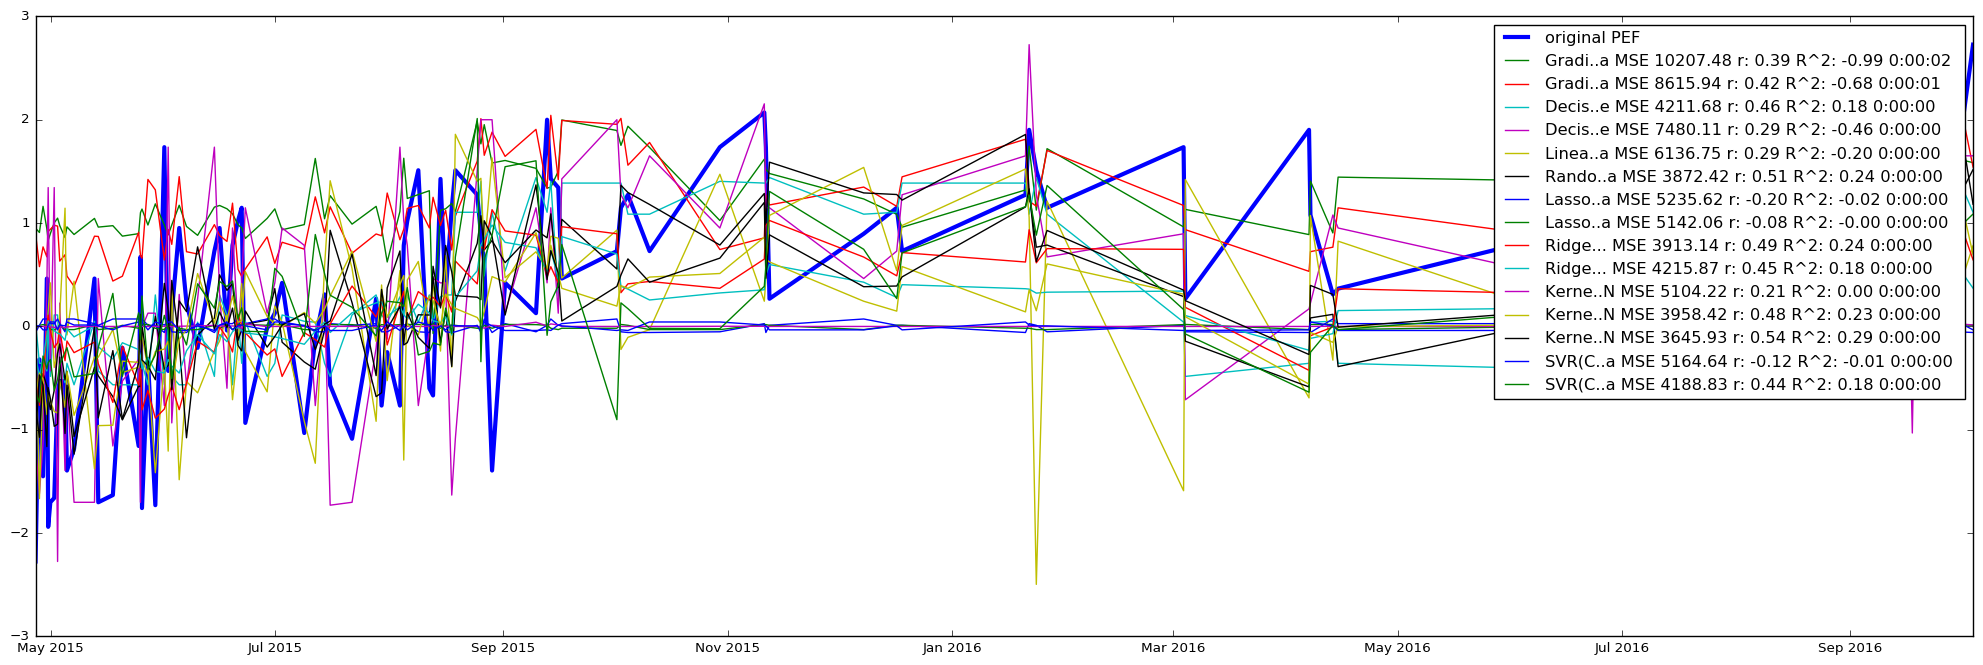

In [12]:
rclfs={}
plt.figure(figsize=(25, 8))
h1, h2 =-100, None
#h1, h2 =500, 550
plt.plot(dp.index[h1:h2], y[h1:h2], label='original PEF', linewidth=3)


for i, r in enumerate(clfs):
    d1 = datetime.datetime.now()
    print ("+Run Start {:2} {} : {}".format(i, d1, str(r)[0:25]) , end=' ')
    
    if ( rclfs.get(str(r)) is not None ):
        yp, mse, clf, r, r2, dur = rclfs[str(r)] 
        print ("EXISTS: using MSE: {} ".format(str(r)[0:15]), mse, end=' ')
    else:
        yp, mse,r, r2, clf = run_reg(X,y, None, True, r, Y_SCALER)
        d2 = datetime.datetime.now()
        dur = d2 -d1;
        dur = dur - datetime.timedelta(microseconds=dur.microseconds)
        rclfs[str(clf)]=(yp, mse, (clf), r, r2, dur ) 
    
    l='{} MSE {:07.2f} r: {:3.2f} R^2: {:3.2f} {} '.format( str(clf)[0:5]+'..'+str(clf)[-5], mse, r, r2, str(dur) ) 
    print('-', l)
    
    plt.plot(dp.index[h1:h2], yp[h1:h2], label=l )
    #if ( i > 11):
    #    break;

plt.legend()

In [13]:
rdf = pd.DataFrame.from_dict(rclfs, orient='index')
rdf.columns = 'y_pred,mse,clf,r,R2,time_to_run'.split(',')
rdf.insert(1,'DTW',0)
rdf.insert(3,'sum',0)
#rdf.clf=rdf.clf.astype(str)
rdf['DTW'] = 0; #rdf.y_pred.apply(lambda x: DTW(x,y))
rdf['sum'] = rdf.y_pred.apply(sum)
rdf= rdf.sort('R2,DTW,mse,sum'.split(','), ascending=[0,1,1,1])
HTML(rdf.to_html())


,y_pred,DTW,mse,sum,clf,r,R2,time_to_run
"KernelRidge(alpha=0.1, coef0=1, degree=3, gamma=0.1, kernel='rbf',\n kernel_params=None)",0 0.652 1 0.512 2 0.863 3 0.15...,0,3645.930,-10.241,"KernelRidge(alpha=0.1, coef0=1, degree=3, gamm...",0.544,0.288,00:00:00
"RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_split=1e-07, min_samples_leaf=1,\n min_samples_split=2, min_weight_fraction_leaf=0.0,\n n_estimators=10, n_jobs=1, oob_score=False, random_state=0,\n verbose=0, warm_start=False)",0 0.729 1 0.679 2 0.955 3 0.35...,0,3872.422,2.684,"(DecisionTreeRegressor(criterion='mse', max_de...",0.511,0.244,00:00:00
"Ridge(alpha=50, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",0 -0.143 1 -0.125 2 0.013 3 -...,0,3913.139,-1.796,"Ridge(alpha=50, copy_X=True, fit_intercept=Tru...",0.486,0.236,00:00:00
"KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',\n kernel_params=None)",0 0.288 1 0.322 2 0.619 3 0.17...,0,3958.417,-13.706,"KernelRidge(alpha=1, coef0=1, degree=3, gamma=...",0.484,0.227,00:00:00
"SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',\n kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)",0 0.667 1 -0.075 2 0.399 3 ...,0,4188.827,-3.116,"SVR(C=1, cache_size=200, coef0=0.0, degree=2, ...",0.435,0.182,00:00:00
"DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,\n max_leaf_nodes=None, min_impurity_split=1e-07,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort=False, random_state=None,\n splitter='best')",0 0.042 1 -0.431 2 0.111 3 -...,0,4211.682,5.948,"DecisionTreeRegressor(criterion='mse', max_dep...",0.456,0.178,00:00:00
"Ridge(alpha=500, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",0 -0.127 1 -0.111 2 -0.087 3 -...,0,4215.872,1.074,"Ridge(alpha=500, copy_X=True, fit_intercept=Tr...",0.445,0.177,00:00:00
"KernelRidge(alpha=5, coef0=1, degree=1, gamma=1.1, kernel='rbf',\n kernel_params=None)",0 0.000 1 0.002 2 0.003 3 0.00...,0,5104.217,-0.221,"KernelRidge(alpha=5, coef0=1, degree=1, gamma=...",0.208,0.004,00:00:00
"Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=100000.0,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",0 -0.017 1 -0.017 2 0.019 3 -...,0,5142.060,-0.022,"Lasso(alpha=0.5, copy_X=True, fit_intercept=Tr...",-0.081,-0.004,00:00:00
"SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1000,\n kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)",0 0.006 1 -0.039 2 0.043 3 -...,0,5164.643,-0.392,"SVR(C=1, cache_size=200, coef0=0.0, degree=3, ...",-0.116,-0.008,00:00:00


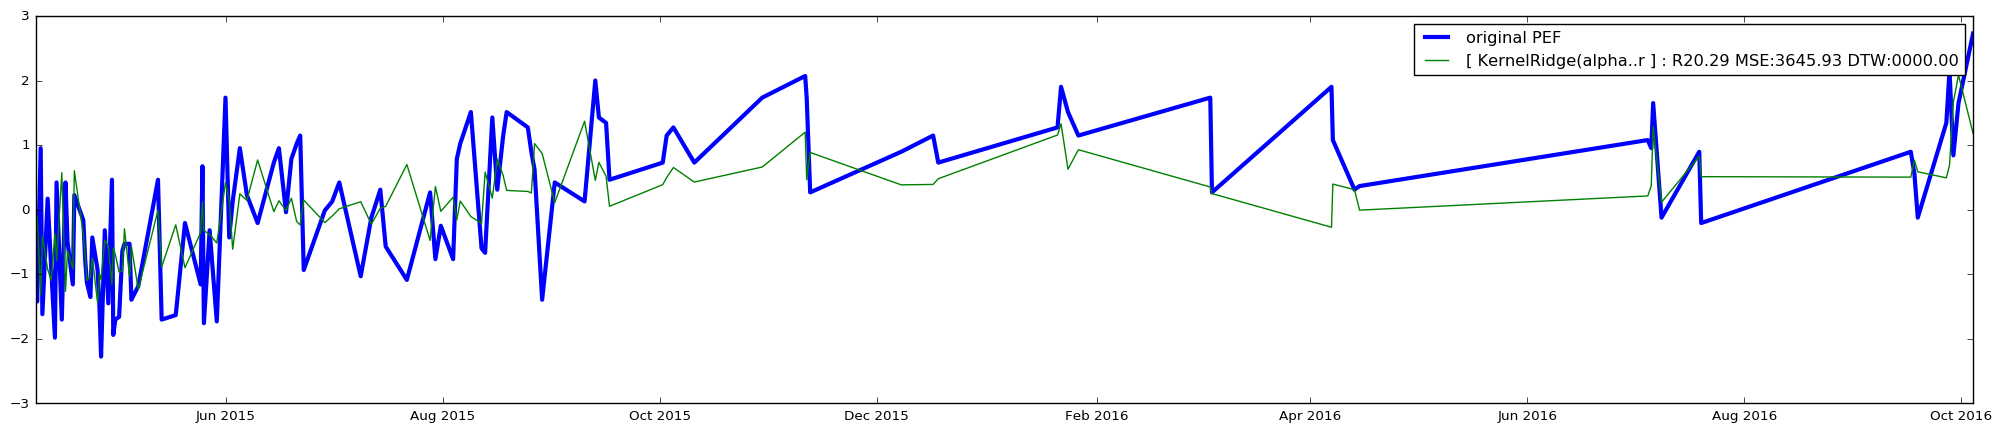

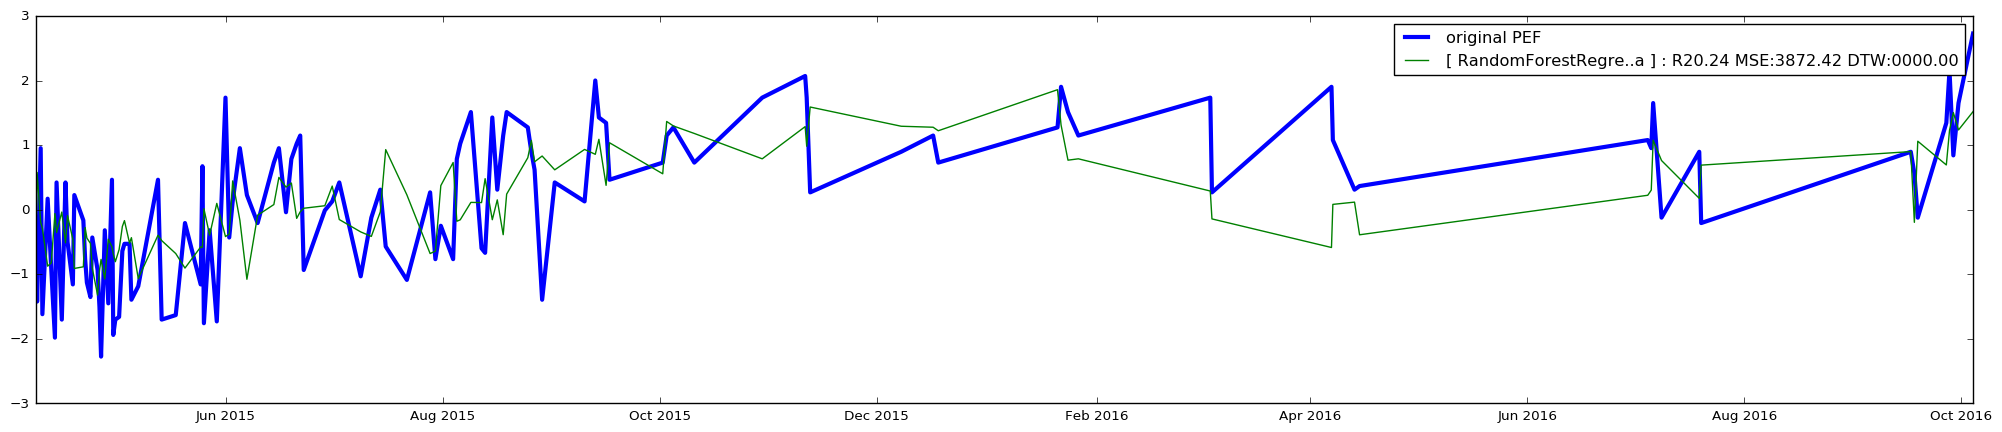

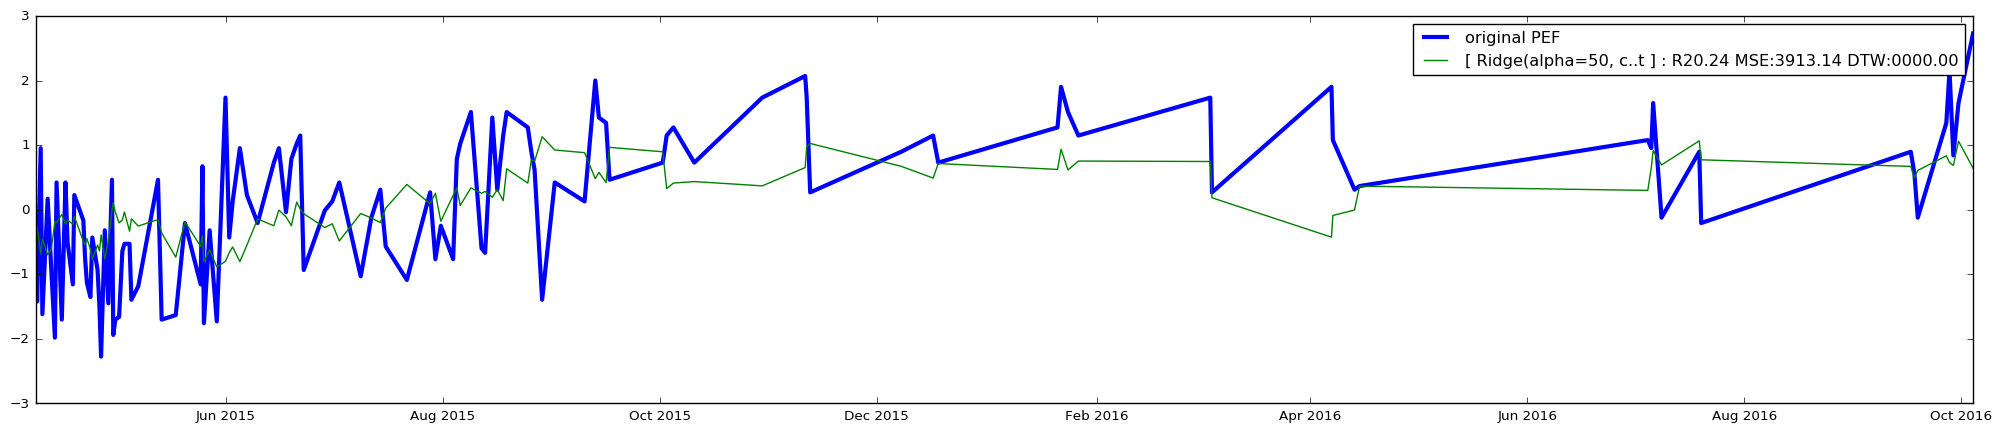

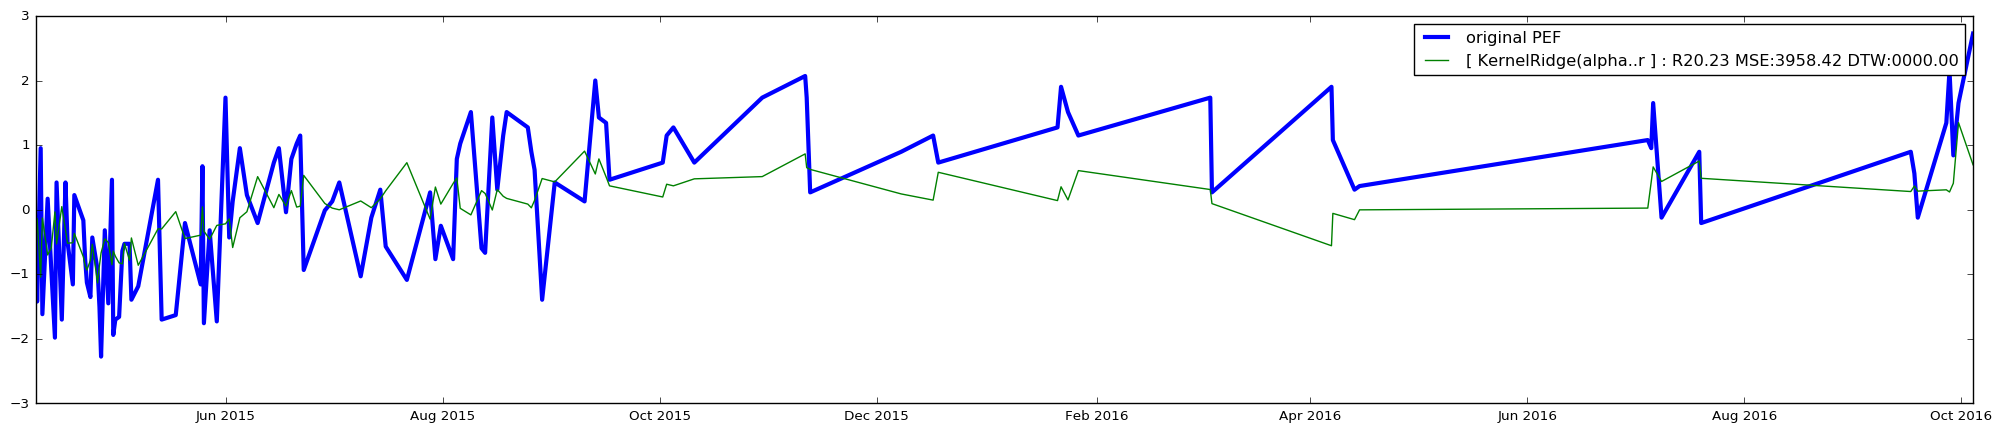

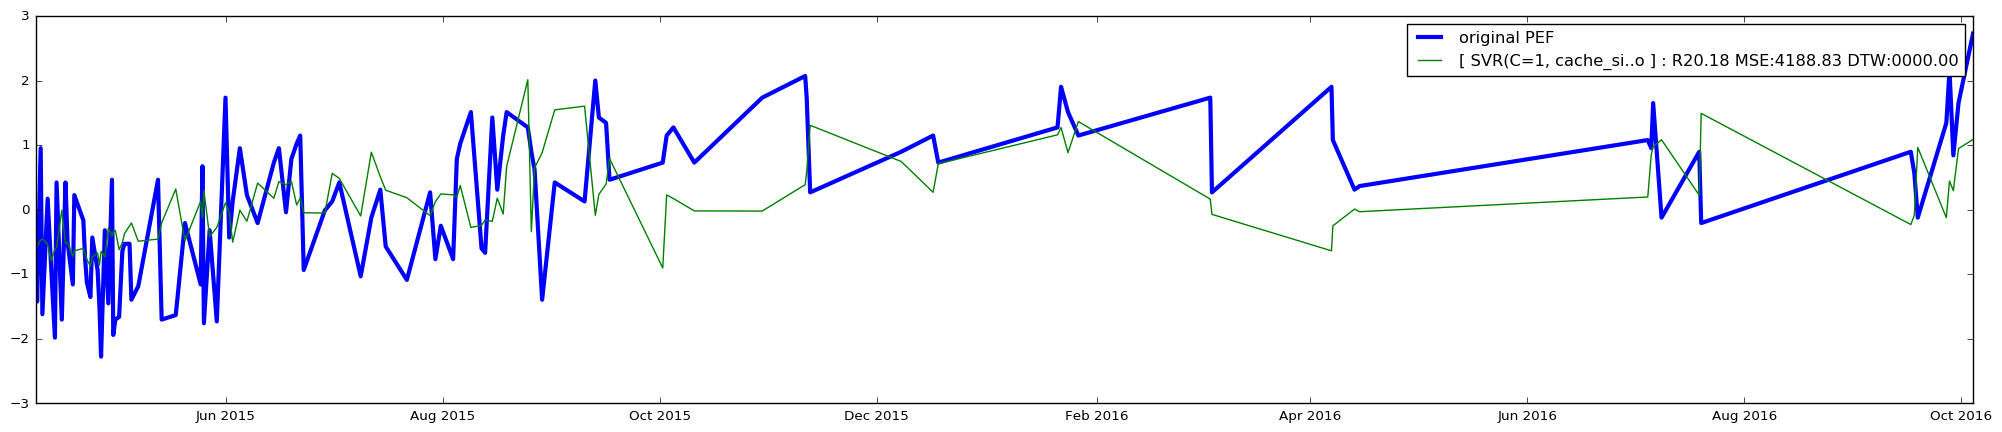

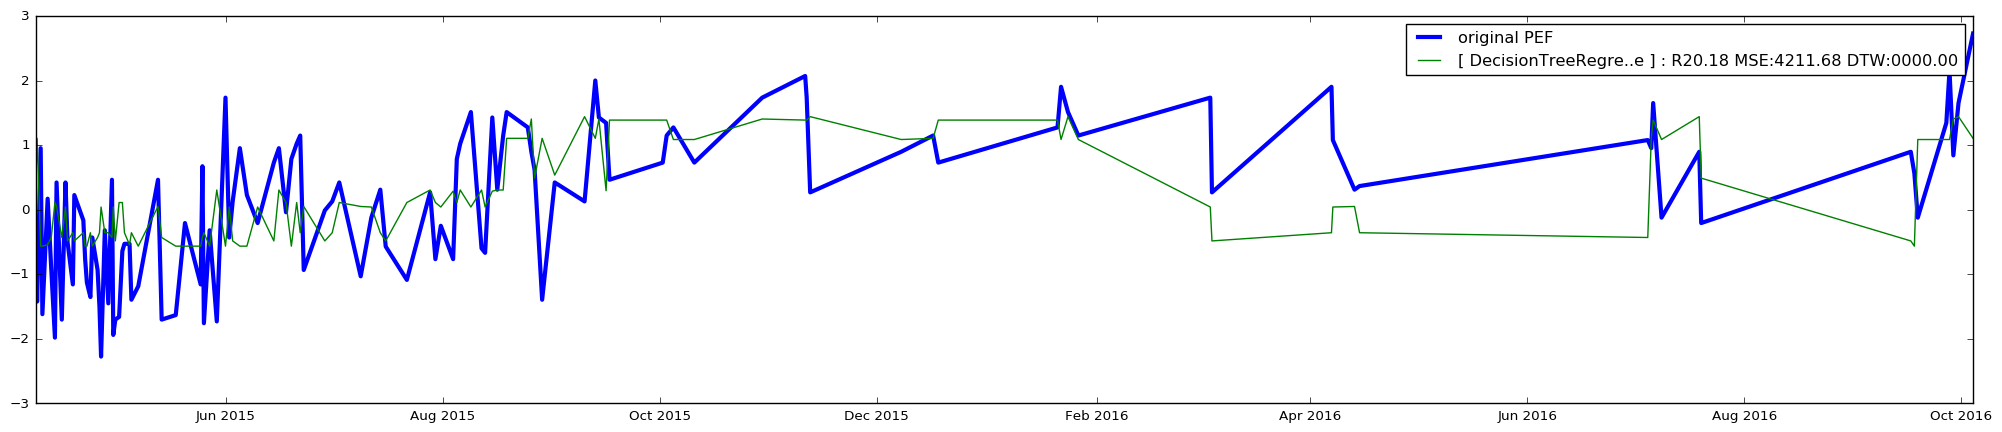

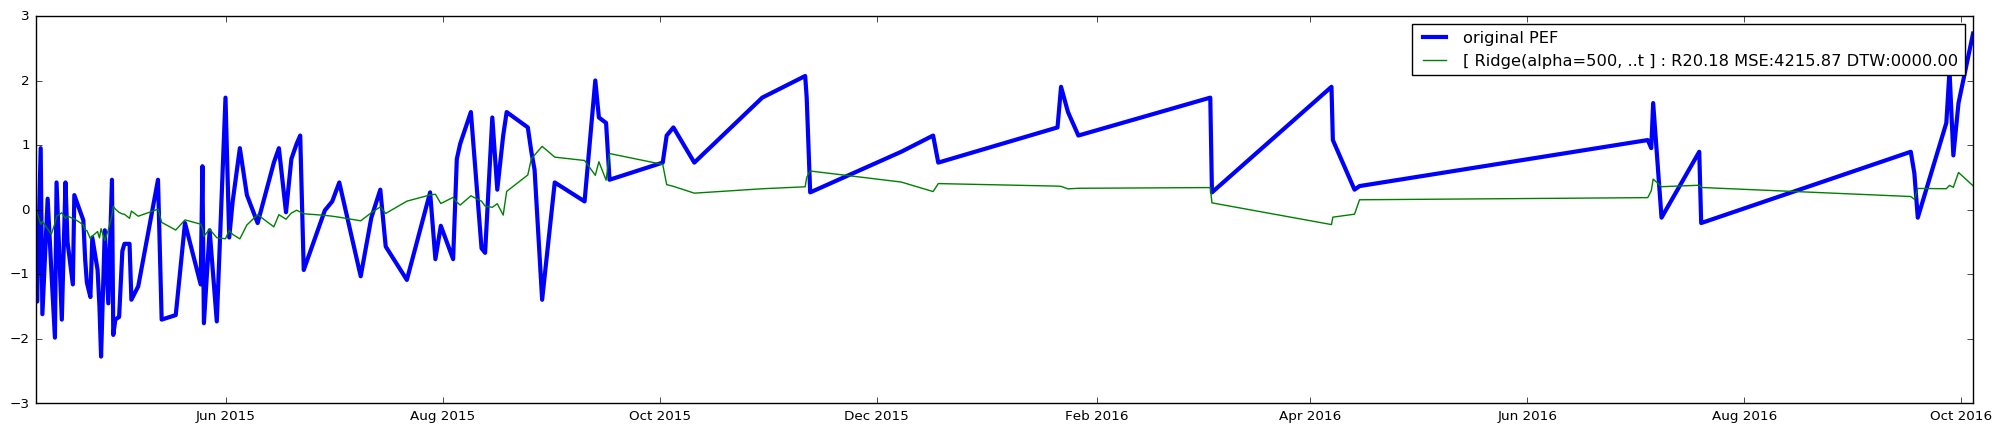

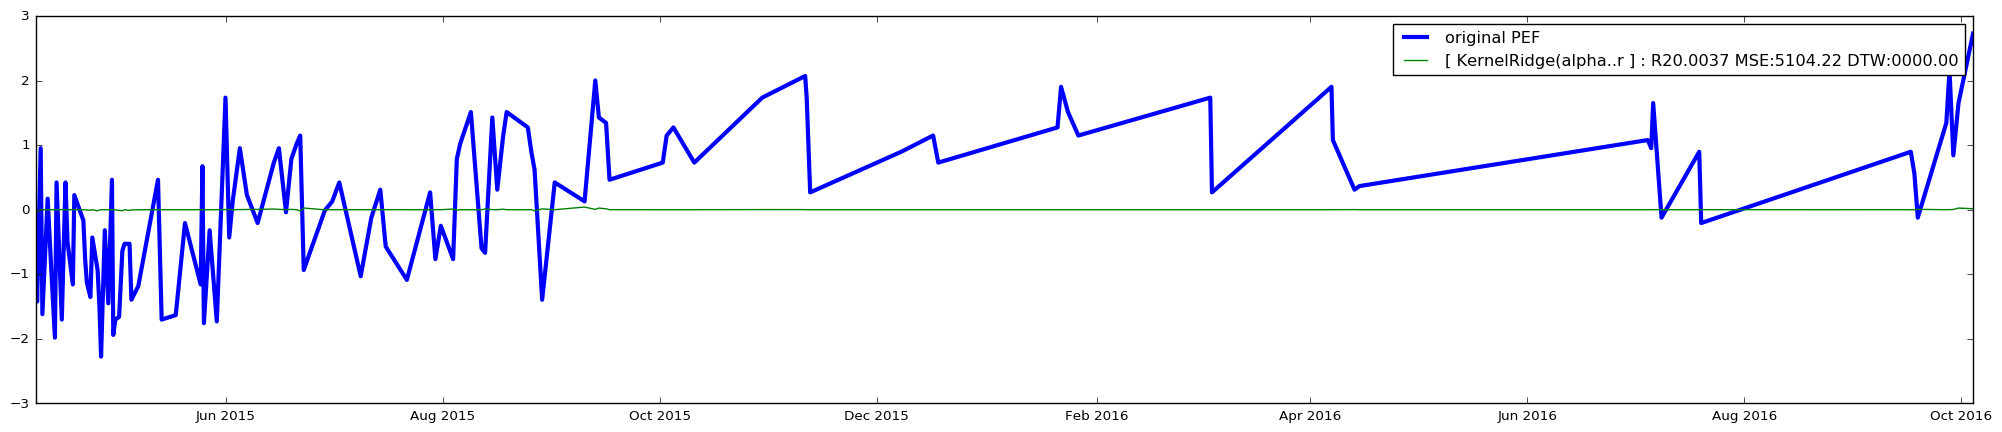

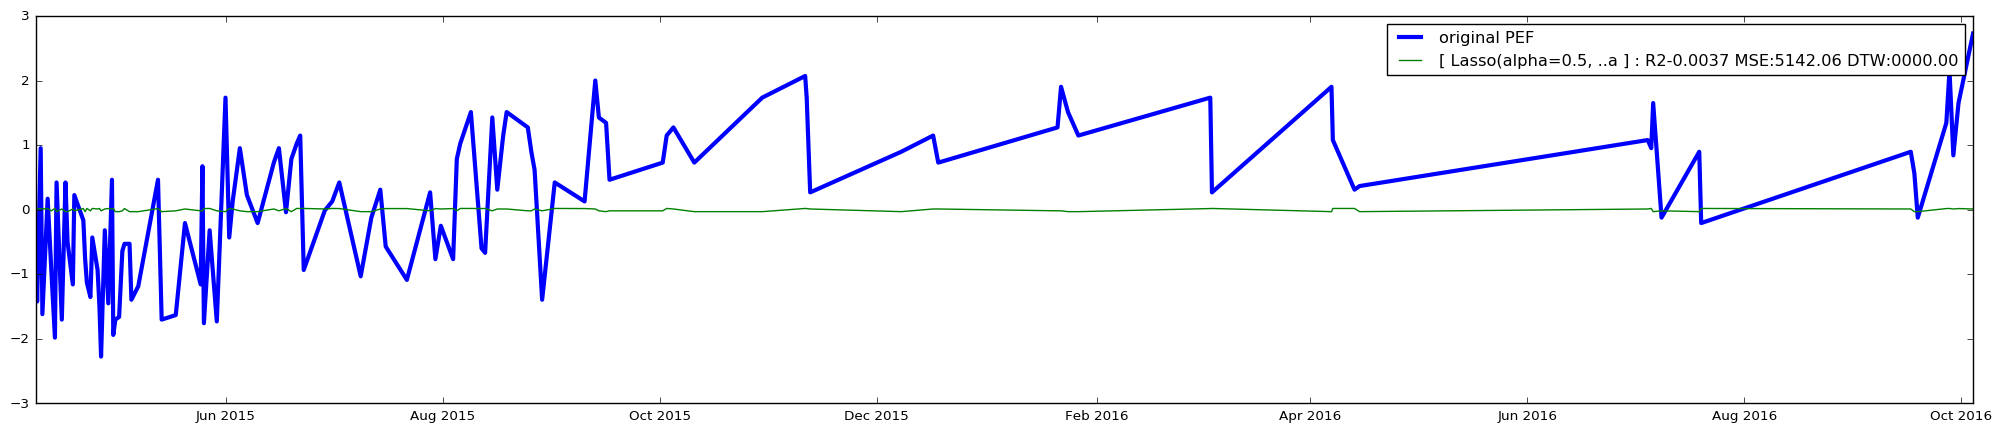

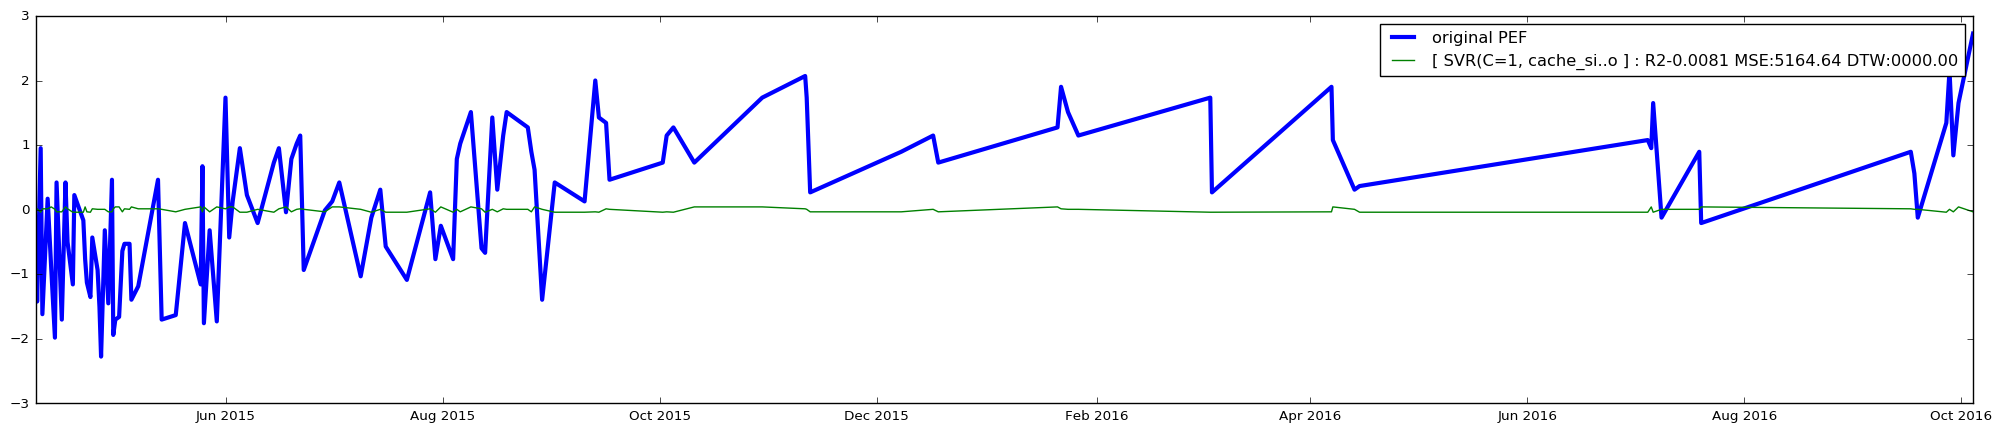

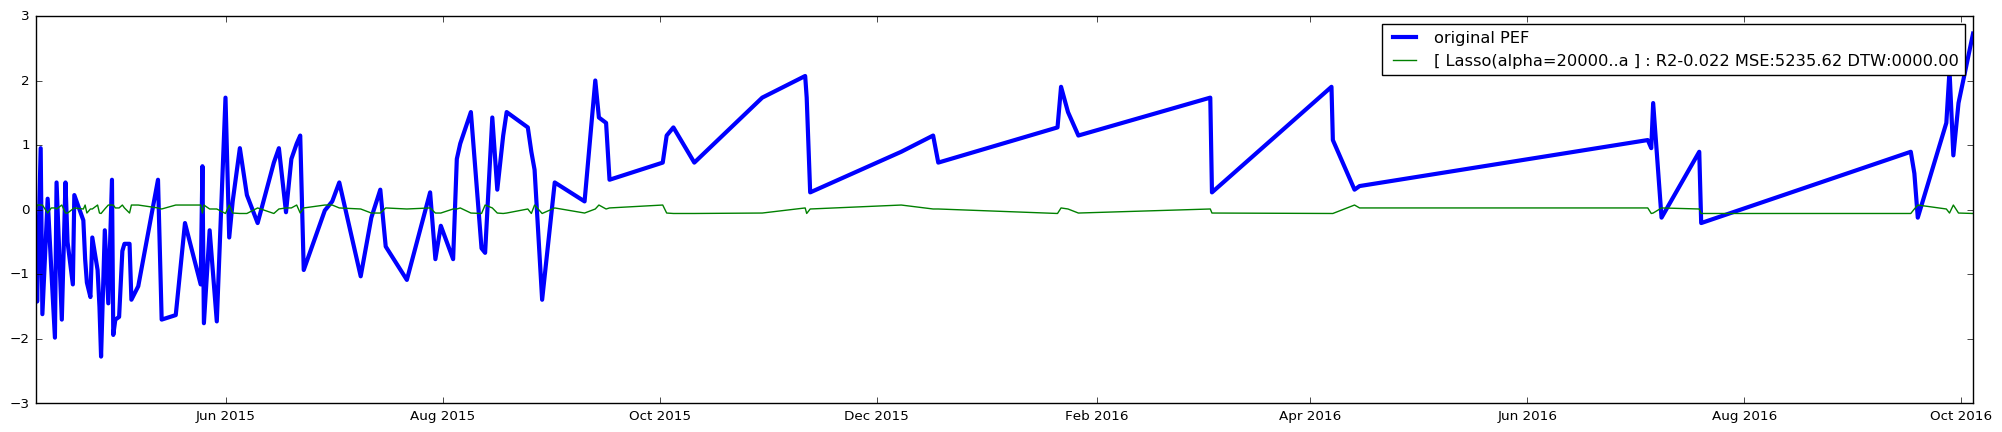

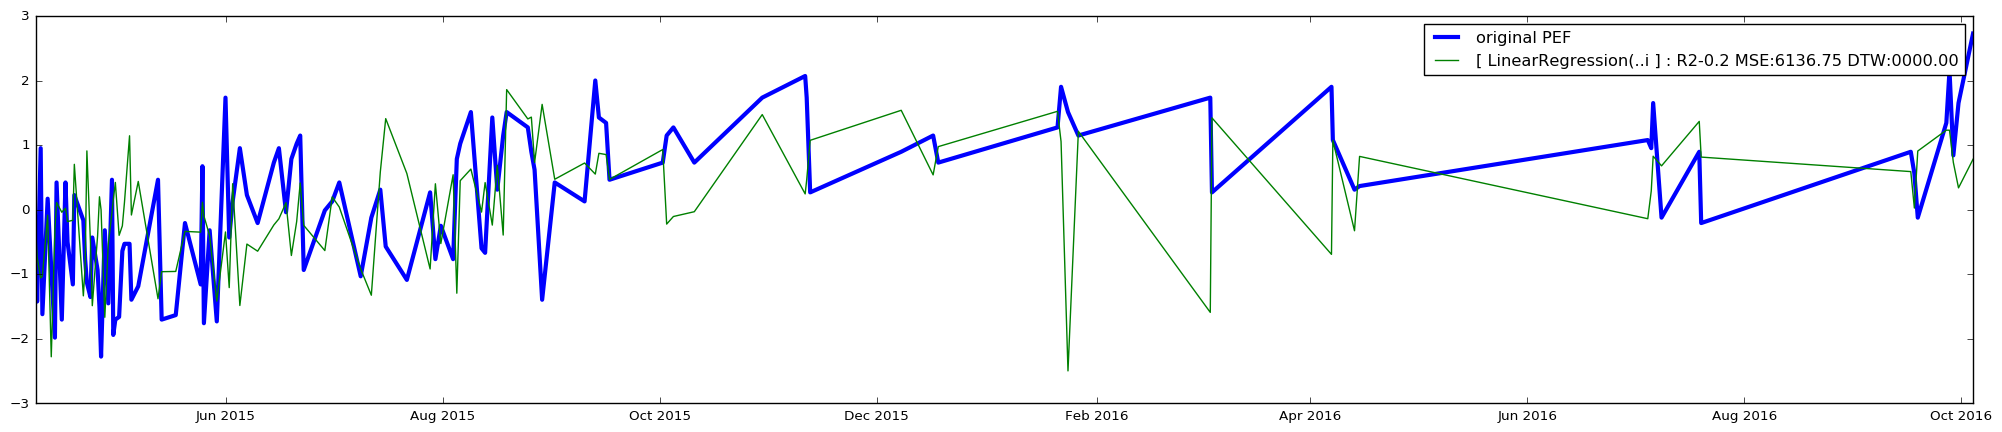

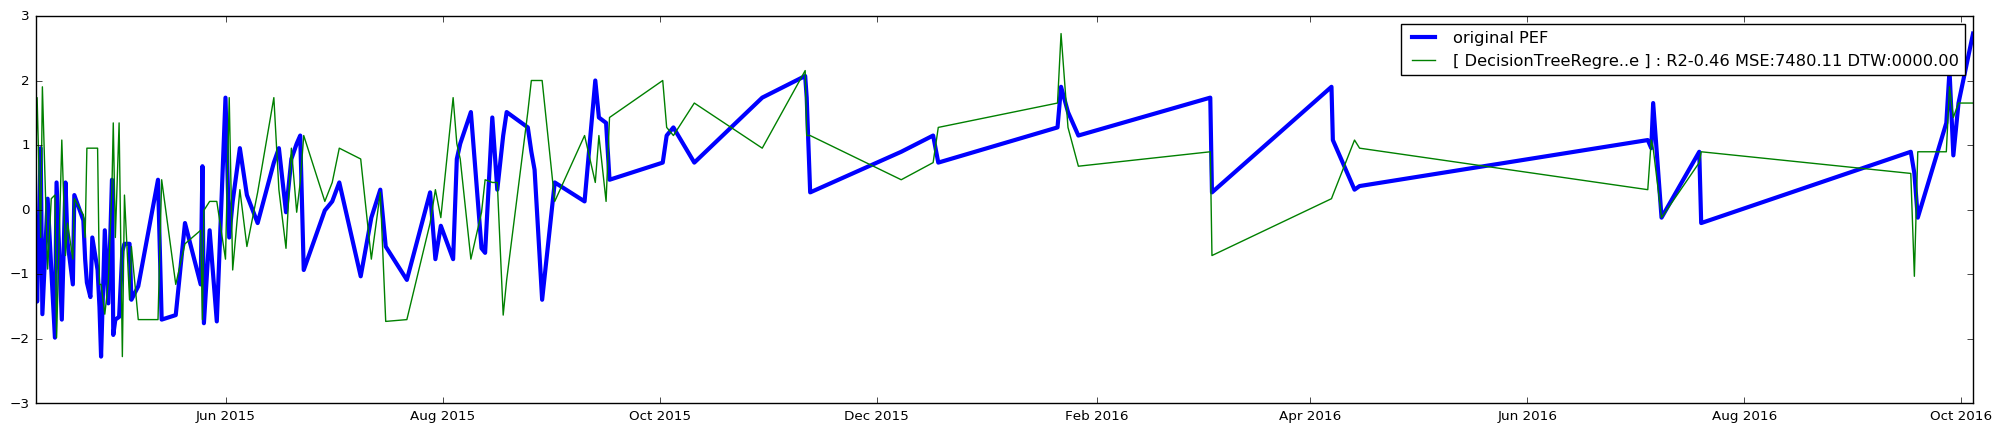

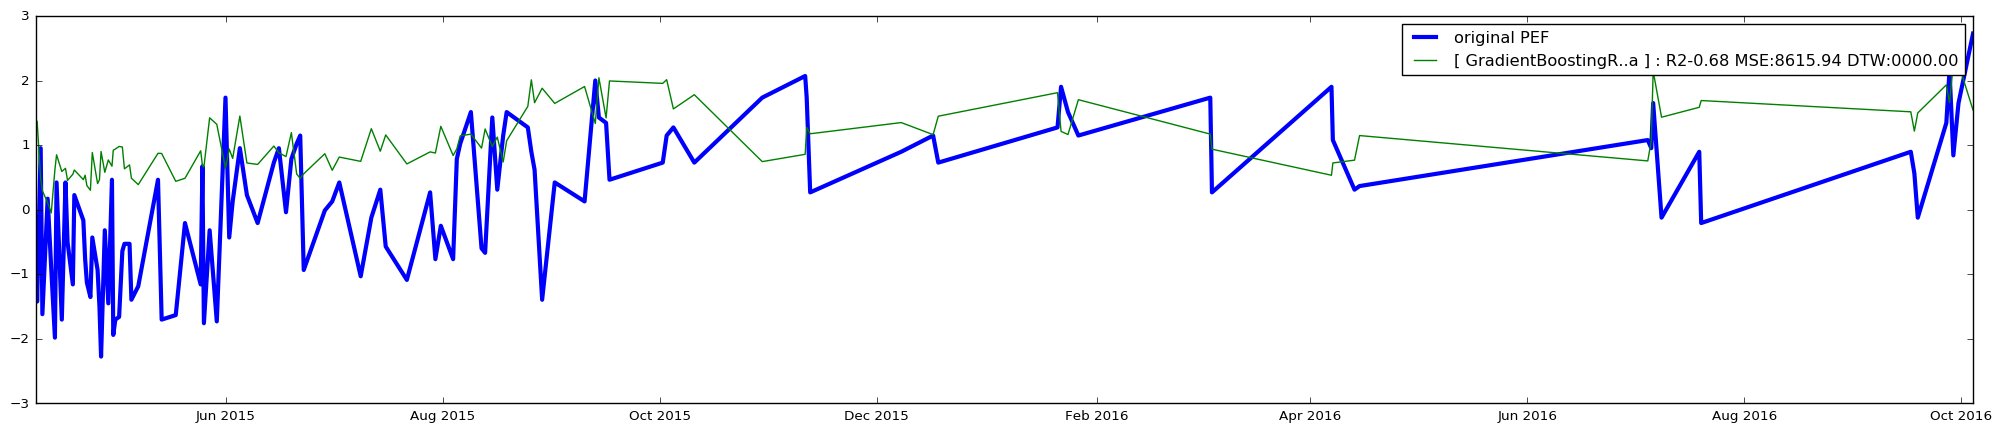

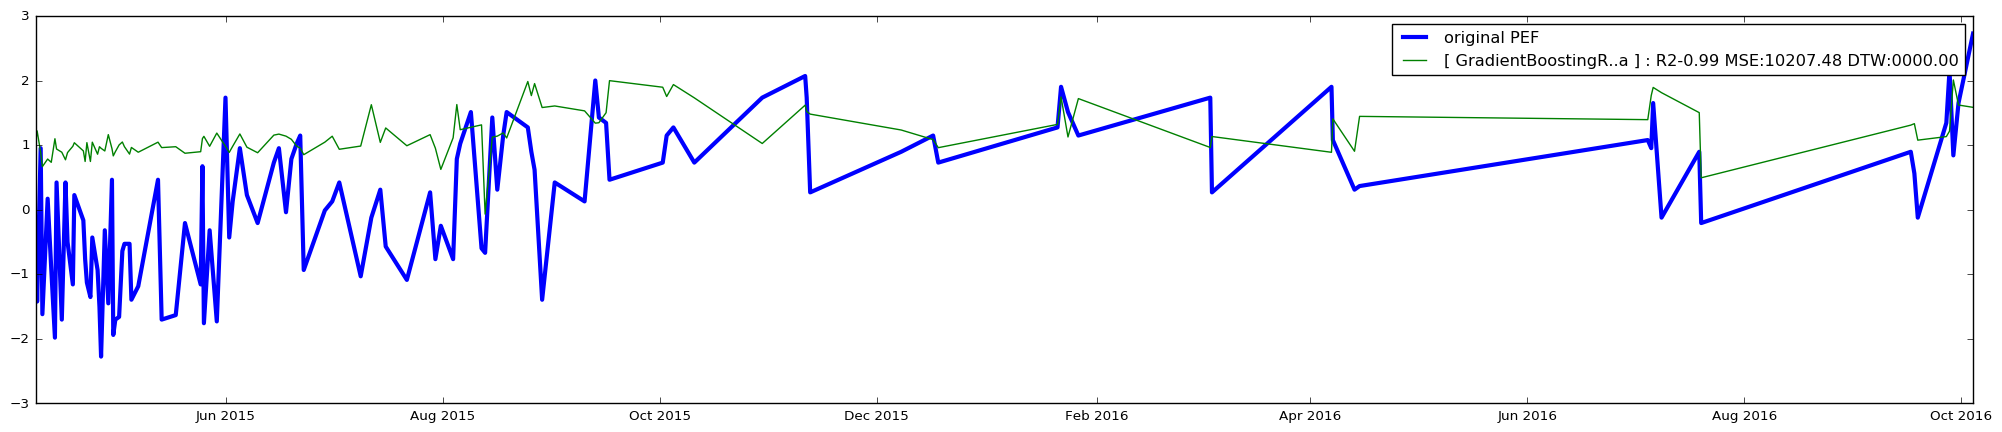

In [17]:
#Lets print individual results
h1=-120
h2=None
for i, r in enumerate(rdf.iterrows()):
    clf = str(r[1][4]);
    mse = r[1][2]
    dtw = r[1][1]
    R2  = r[1][6]
    dur = r[1][-1]
    l='[ {} ] : MSE:{:07.2f} DTW:{:07.2f} {} {}'.format( str(clf)[0:17]+'..'+str(clf)[-10], mse, dtw, str(dur), poly)
    R2  = r[1][6]
    l='[ {} ] : R2{:4.2} MSE:{:07.2f} DTW:{:07.2f}'.format( str(clf)[0:17]+'..'+str(clf)[-10], R2, mse, dtw)
    plt.figure(figsize=(25, 5))
    plt.plot(dp.index[h1:h2], y[h1:h2], label='original PEF', linewidth=3)
    plt.plot(dp.index[h1:h2], r[1][0][h1:h2], linewidth=1, label=l)
    plt.legend()
    plt.show()

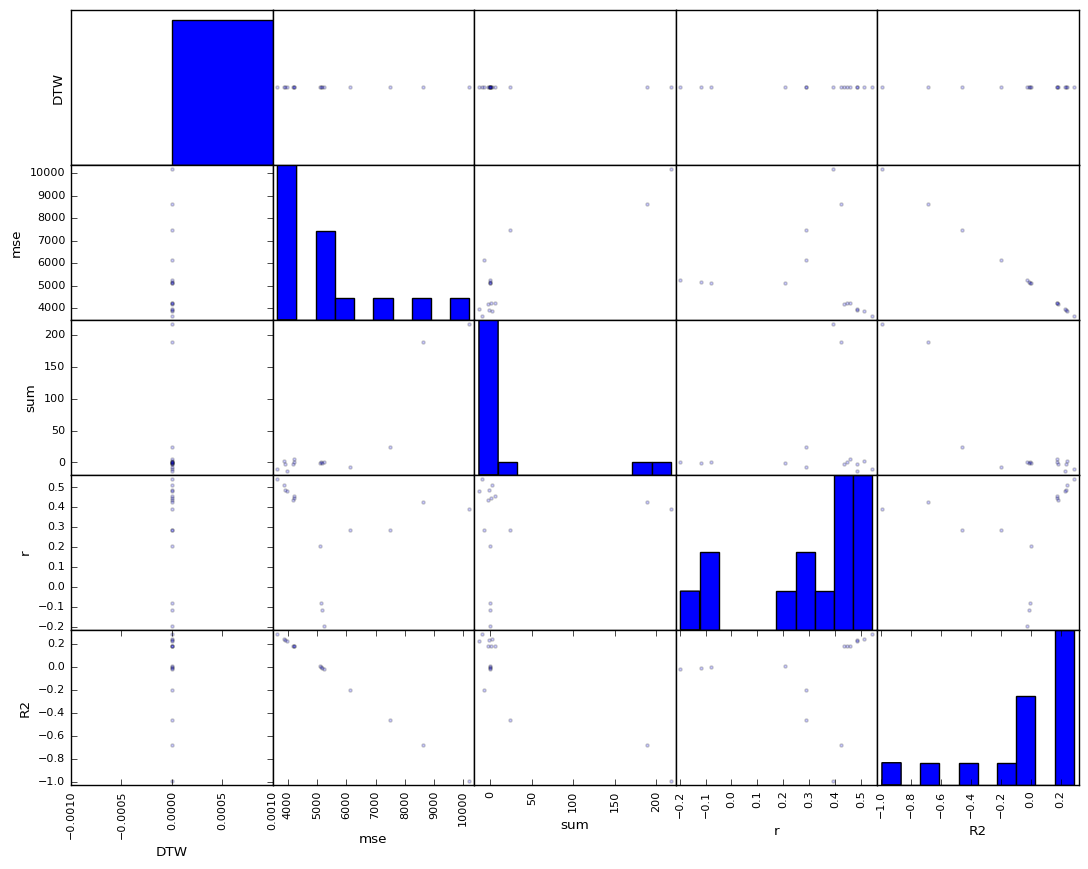

In [18]:
#axes = scatter_matrix(rdf, alpha=0.2, diagonal='hist', figsize=(13, 10)); # diagonal can be 'hist';


In [ ]:
r1 = rdf[rdf.mse <= 1600]

plt.figure(figsize=(6, 6))
plt.scatter(r1.mse, r1.DTW)
plt.grid()
plt.xlabel("MSE")
plt.ylabel("DTW")



In [ ]:
'''
POlynomial degree 1 has the following results

GradientBoostingRegressor  MSE 2470.60 r: 0.19  R^2: -2.22 0:00:03 
GradientBoostingRegressor  MSE 1575.88 r: 0.24  R^2: -1.05 0:00:01 
DecisionTreeRegressor(cri  MSE 0758.55 r: 0.20  R^2: 0.01 0:00:00 
DecisionTreeRegressor(cri  MSE 1241.32 r: 0.22  R^2: -0.62 0:00:00 
LinearRegression(copy_X=T  MSE 0699.95 r: 0.31  R^2: 0.09 0:00:00 
RandomForestRegressor(boo  MSE 0759.59 r: 0.27  R^2: 0.01 0:00:00 
Lasso(alpha=20000, copy_X  MSE 0769.67 r: -0.06 R^2: -0.00 0:00:00 
Lasso(alpha=0.5, copy_X=T  MSE 0770.17 r: -0.07 R^2: -0.00 0:00:00 
Ridge(alpha=50, copy_X=Tr  MSE 0693.19 r: 0.31  R^2: 0.10 0:00:00 
Ridge(alpha=500, copy_X=T  MSE 0712.64 r: 0.28  R^2: 0.07 0:00:00 
KernelRidge(alpha=1, coef  MSE 0685.84 r: 0.34  R^2: 0.11 0:00:00 
SVR(C=1, cache_size=200,   MSE 0777.55 r: -0.12 R^2: -0.01 0:00:00 
SVR(C=500, cache_size=200  MSE 0927.78 r: 0.29  R^2: -0.21 0:00:12 


POLYNOMIAL Degree 2:
GradientBoostingRegressor  MSE 3389.86 r: 0.03  R^2: -3.41 0:00:22 
GradientBoostingRegressor  MSE 1753.38 r: 0.21  R^2: -1.28 0:00:13 
DecisionTreeRegressor(cri  MSE 0785.32 r: 0.13  R^2: -0.02 0:00:00 
DecisionTreeRegressor(cri  MSE 1242.66 r: 0.16  R^2: -0.62 0:00:00 
LinearRegression(copy_X=T  MSE 2300.86 r: 0.14  R^2: -2.00 0:00:00 
RandomForestRegressor(boo  MSE 0759.73 r: 0.26  R^2: 0.01  0:00:01 
Lasso(alpha=20000, copy_X  MSE 0773.09 r: -0.11 R^2: -0.01 0:00:00 
Lasso(alpha=0.5, copy_X=T  MSE 0773.62 r: -0.11 R^2: -0.01 0:00:00 
Ridge(alpha=50, copy_X=Tr  MSE 0719.43 r: 0.29  R^2: 0.06  0:00:00 
Ridge(alpha=500, copy_X=T  MSE 0708.72 r: 0.28  R^2: 0.08  0:00:00 
KernelRidge(alpha=1, coef  MSE 0757.13 r: 0.13  R^2: 0.01  0:00:00 
SVR(C=1, cache_size=200,   MSE 0776.06 r: -0.08 R^2: -0.01 0:00:00 
SVR(C=500, cache_size=200  MSE 3380.81 r: 0.10  R^2: -3.40 0:00:01 

'''


'results of combined sum of exposure for 2,3,4,5 days'

'''
-
'''